In [1]:
import geopandas as gpd
import os
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube

In [2]:
def components_to_speed(vx_path, vy_path):
    '''this function reads in x,y components of velocity, generates speed variable. return xarray
    dataset w/ x,y, speed variables. function will break if vx,vy objects don"t have same x,y coords'''
    
    vy_ds = rxr.open_rasterio(vy_path, masked=False).squeeze()
    vx_ds = rxr.open_rasterio(vx_path, masked=False).squeeze()
    
    ds_gen = xr.Dataset()
    ds_gen['vx'] = vx_ds
    ds_gen['vy'] = vy_ds
    sp = np.sqrt((ds_gen['vx'].data**2) + ds_gen['vy'].data**2)
    ds_gen['sp'] = (['x','y'], sp.T)
    
    return ds_gen

In [3]:
n45_vy_path = '/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/gardner_data/N45_0240m_vy.tiff'
n45_vx_path = '/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/gardner_data/N45_0240m_vx.tiff'


In [4]:
#make raster data w/ velocity component and speed variables for a single tiff file from Alex Gardner (single utm zone)
ds_45n = components_to_speed(n45_vx_path, n45_vy_path)


In [5]:
#read in vector data 
se_asia = gpd.read_file('/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/rgi_1km/se_asia_1km.shp')
sw_asia = gpd.read_file('/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/rgi_1km/sw_asia_1km.shp')
c_asia = gpd.read_file('/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/rgi_1km/central_asia_1km.shp') 

se_asia_path = '/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/rgi_1km/se_asia_1km.shp'
sw_asia_path = '/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/rgi_1km/sw_asia_1km.shp'
c_asia_path = '/Users/emmamarshall/OneDrive - University of Utah/nisar_prepwork/rgi_1km/central_asia_1km.shp'




In [6]:
se_asia_100 = se_asia.iloc[:100,:]
ds_45n

<xarray.Dataset>
Dimensions:      (x: 4440, y: 27072)
Coordinates:
    band         int64 1
  * x            (x) float64 -3.253e+04 -3.229e+04 ... 1.033e+06 1.033e+06
  * y            (y) float64 6.297e+06 6.297e+06 ... -1.993e+05 -1.996e+05
    spatial_ref  int64 0
Data variables:
    vx           (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    vy           (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    sp           (x, y) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan

In [7]:
def rasterize_vector(gpdf, utm_code, raster_obj): 
    
    #read in gpdf from shp file
    #gpdf = gpd.read_file(vector_path)
    #project to local utm
    gpdf_utm = gpdf.to_crs(f'EPSG:{utm_code}')
    #use index as a unique key for each glacier
    gpdf_utm['Integer_ID'] = gpdf_utm.index.astype(int)
    #print(gpdf_utm['Integer_ID'])
    
    #rasterize glacier vector by unique id 

    out_grid = make_geocube(
            vector_data = gpdf_utm,
            measurements = ['Integer_ID'],
            like = raster_obj['sp'] #need to specify a var here, not sure best way to do that
            )
    
    #now merge the rasterized vector and the original raster togehter into a geocube
    out_grid['speed'] = (raster_obj.dims, raster_obj.sp.values, raster_obj.attrs, raster_obj.encoding)
    
    #now, get velocity statistics of each 'region' (integer) using the mask
    grouped_ID = out_grid.drop('spatial_ref').groupby(out_grid.Integer_ID)

    #compute zonal stats groupedd by ID
    grid_mean_sp = grouped_ID.mean().rename({'speed': 'speed_mean'})
    grid_min_sp = grouped_ID.min().rename({'speed': 'speed_min'})
    grid_max_sp = grouped_ID.max().rename({'speed': 'speed_max'})
    grid_std_sp = grouped_ID.max().rename({'speed': 'speed_std'})
    
    #merge each zonal stat xr obj into a single xr obj, convert to pandas df
    zonal_stats = xr.merge([grid_mean_sp, grid_min_sp, grid_max_sp, grid_std_sp]).to_dataframe()
    zonal_stats = zonal_stats.reset_index()
    
    return zonal_stats

In [8]:
rasterize_vector_seasia_100 = rasterize_vector(se_asia_100, 32645, ds_45n)
rasterize_vector_seasia_100

ValueError: Failed to group data. Are you grouping by a variable that is all NaN?

In [ ]:
rasterize_vector_seasia_100.plot.scatter(x='Integer_ID', y='speed_mean',c='darkblue')

<AxesSubplot:xlabel='Integer_ID', ylabel='Area'>

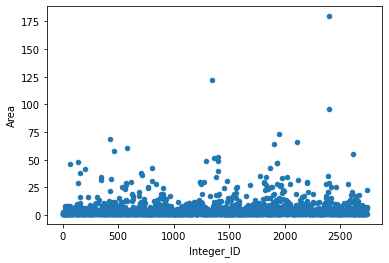

In [9]:
#project to utm
se_asia_utm = se_asia.to_crs('EPSG:32645')
#make a col in df that is a unique integer ID (from index) for each glacier
se_asia_utm['Integer_ID'] = se_asia_utm.index.astype(int)
#double checking that all glaciers are assigned an ID
se_asia_utm.plot.scatter(x='Integer_ID', y='Area')

In [10]:
#rasterize glacier vector by unique id 
#
out_grid_se_asia = make_geocube(
            vector_data = se_asia_utm,
            measurements = ['Integer_ID'],
            like = ds_45n['sp']
)

In [11]:
#now merge the rasterized vector and the original raster togehter into a geocube
out_grid_se_asia['speed'] = (ds_45n.dims, ds_45n.sp.values, ds_45n.attrs, ds_45n.encoding)
out_grid_se_asia

<xarray.Dataset>
Dimensions:      (y: 27072, x: 4440)
Coordinates:
  * y            (y) float64 6.297e+06 6.297e+06 ... -1.993e+05 -1.996e+05
  * x            (x) float64 -3.253e+04 -3.229e+04 ... 1.033e+06 1.033e+06
    spatial_ref  int64 0
Data variables:
    Integer_ID   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    speed        (x, y) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan

In [34]:
out_grid_se_asia.variables

Frozen({'Integer_ID': <xarray.Variable (y: 27072, x: 4440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Attributes:
    name:        Integer_ID
    long_name:   Integer_ID
    _FillValue:  nan, 'y': <xarray.IndexVariable 'y' (y: 27072)>
array([6297487.5, 6297247.5, 6297007.5, ..., -199072.5, -199312.5, -199552.5])
Attributes:
    axis:           Y
    long_name:      y coordinate of projection
    standard_name:  projection_y_coordinate
    units:          metre, 'x': <xarray.IndexVariable 'x' (x: 4440)>
array([ -32527.5,  -32287.5,  -32047.5, ..., 1032352.5, 1032592.5, 1032832.5])
Attributes:
    axis:           X
    long_name:      x coordinate of projection
    standard_name:  projection_x_coordinate
    units:          metre, 'spatial_ref': <xarray.Var

In [12]:
#trying to figure out why 1300 glaciers or so get dropped
print(len(out_grid_se_asia.Integer_ID))

27072


In [13]:
#now, get velocity statistics of each 'region' (integer) using the mask
grouped_ID = out_grid_se_asia.drop('spatial_ref').groupby(out_grid_se_asia.Integer_ID)
grouped_ID

DatasetGroupBy, grouped over 'Integer_ID'
1340 groups with labels 248.0, 249.0, ..., 2.738e+03.

In [14]:
grid_mean_sp = grouped_ID.mean().rename({'speed': 'speed_mean'})
grid_median_sp = grouped_ID.median().rename({'speed': 'speed_median'})
grid_min_sp = grouped_ID.min().rename({'speed': 'speed_min'})
grid_max_sp = grouped_ID.max().rename({'speed': 'speed_max'})
grid_std_sp = grouped_ID.max().rename({'speed': 'speed_std'})

In [15]:
zonal_stats = xr.merge([grid_mean_sp, grid_median_sp, grid_min_sp, grid_max_sp, grid_std_sp]).to_dataframe()
zonal_stats = zonal_stats.reset_index()
zonal_stats

,Integer_ID,speed_mean,spatial_ref,speed_median,speed_min,speed_max,speed_std
0,248.0,14.529323,0,4.284127,0.268140,85.758003,85.758003
1,249.0,0.820514,0,0.763270,0.147464,2.407174,2.407174
2,250.0,3.385211,0,3.357724,0.139246,8.420528,8.420528
3,251.0,3.185188,0,2.607560,0.136739,9.884713,9.884713
4,252.0,1.109952,0,0.804390,0.186464,3.140323,3.140323
...,...,...,...,...,...,...,...
1335,2209.0,1.090179,0,1.076497,0.069885,4.057207,4.057207
1336,2210.0,11.063942,0,8.688779,0.106999,33.059551,33.059551
1337,2211.0,0.807759,0,0.611025,0.157515,2.715099,2.715099
1338,2737.0,0.854855,0,0.733067,0.222202,2.046064,2.046064


In [16]:
#now, trying to merge zonal stats df back with original glacier df on integer_ID col
se_asia_glacier_data = se_asia_utm.merge(zonal_stats, on='Integer_ID')


<AxesSubplot:xlabel='Integer_ID', ylabel='speed_mean'>

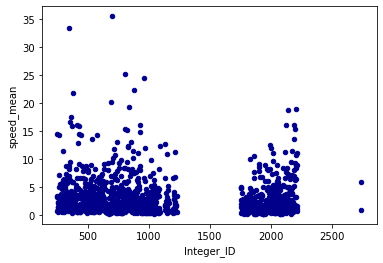

In [17]:
zonal_stats['speed_mean']

fig, ax = plt.subplots()
se_asia_glacier_data.plot.scatter(x='Integer_ID',y = 'speed_mean', c = 'darkblue', ax=ax)


In [18]:
zonal_stats['speed_mean'].min()

0.21297143

<AxesSubplot:>

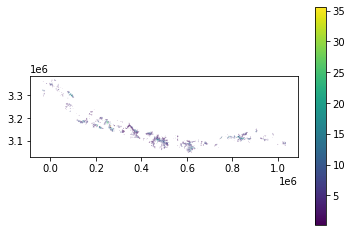

In [19]:
se_asia_glacier_data.plot(column='speed_mean', legend=True)